<a href="https://colab.research.google.com/github/Jalapinho1/Deep-Reinforcement-Learning-Explained/blob/main/Value_Iteration_V_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Value Iteration for V-function**

Libraries and constants

In [2]:
import gym
import collections
from torch.utils.tensorboard import SummaryWriter
ENV_NAME="FrozenLake-v0"
GAMMA = 0.9
TEST_EPISODES = 20
N =100
REWARD_GOAL = 0.8

**Agent's data structures**


The main data structures which will keep Agent’s information are:


*   **rewards**: A dictionary with the composite key “source state” + “action” +“target state”. The value is obtained from the immediate reward.
*   **transits**: A table as a dictionary keeping counters of the experienced transitions. The key is the composite “state” + “action”, and the value is another dictionary that maps the target state into a count of times that we have seen it.
*   **values**: A dictionary that maps a state into the calculated value of this state (V-value)
*   **state**: Current state of the Agent.

**Training Alghoritm**

The overall logic of our training algorithm is simple. Until the desired Reward goal is not reached we will execute the following steps:


1.   play N random steps from the environment to populating the *reward* and *transits* tables.
2.   After those N steps, it performs a value iteration step over all states, updating the *value* table.
3.   Then we play several full episodes to check the improvements using the updated value table.
4.   If the average reward for those test episodes is above the desired boundary, then we stop training.


**Agent Class**

In the Agentclass constructor, we create an Environment that we will be using for data samples, obtain our first observation, and define tables for rewards, transitions, and values:

In [15]:
class Agent: 
      def __init__(self):
          self.env = gym.make(ENV_NAME) 
          self.state = self.env.reset()
          self.rewards = collections.defaultdict(float)
          self.transits = collections.defaultdict(
                        collections.Counter)
          self.values = collections.defaultdict(float)

**Play random steps**

Remember that in the previous post we advanced that the estimation of Transitions and Rewards will be obtained through the history of the Agent’s interaction with the Environment

In [4]:
def play_n_random_steps(self, count):
          for _ in range(count):
              action = self.env.action_space.sample()
              new_state, reward, is_done, _ = self.env.step(action)
              self.rewards[(self.state, action, new_state)] = reward
              self.transits[(self.state, action)][new_state] += 1
              if is_done:
                self.state = self.env.reset()
              else:
                self.state = new_state

Note that we don’t need to wait for the end of the episode to start learning; we just perform N steps and remember their outcomes. This is one of the differences between the Value Iteration and the Cross-Entropy method shown in a previous post, which requires full episodes to learn.

**Value of the action**

The next method calculates the Q-function, the value of an action from a state using the transits, reward, and value tables of the Agent. We will use it for two purposes: to select the best action to perform from the state and to calculate the new value of the state on the Value Iteration algorithm.

In [5]:
def calc_action_value(self, state, action):
    target_counts = self.transits[(state, action)]
    total = sum(target_counts.values())
    
    action_value = 0.0
    for tgt_state, count in target_counts.items():
        reward = self.rewards[(state, action, tgt_state)]
        val = reward + GAMMA * self.values[tgt_state]
        action_value += (count / total) * val
    return action_value

First, from the transits table, we extract transition counters for the given state and action that the method receives as arguments. We sum all counters to obtain the total count of times we have executed the action from the state. Then we iterate every target state that our action has landed on and calculate its contribution to the total action value using the formula presented in the Bellman equation post:

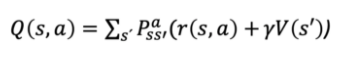


This value is equal to immediate reward plus discounted value for the target state and multiplied this sum to the probability of this transition (individual counter divided by the total value computed before). We add the result for each iteration to a variable action_value, the variable that will be returned.

**Select best Action**

In order to select the best action from a given state, we have the method select_action that uses the previous calc_action_value method to make the decision:

In [6]:
def select_action(self, state):
    best_action, best_value = None, None
    for action in range(self.env.action_space.n):
        action_value = self.calc_action_value(state, action)
        if best_value is None or best_value < action_value:
           best_value = action_value
           best_action = action
    return best_action

The code of this method iterates over all possible actions in the Environment and calculates the value for every action and returns the action with the largest Q-value

**Value Iteration function**

And here we have the main function, that as we described in the previous post, what Value Iteration method do is just loop over all states in the Environment:


In [9]:
def value_iteration(self):
    for state in range(self.env.observation_space.n):
        state_values = [
              self.calc_action_value(state, action)
              for action in range(self.env.action_space.n)
        ]
    self.values[state] = max(state_values)

For every state, we update its value with the maximum value of the action available from the state.

**Training Loop and the monitoring of the code**

After presenting the Agent’s class and its methods, we come back to describe the main loop. First of all, we create the Environment that we will be using for testing, create an instance of the Agent class, the summary writer for TensorBoard, and some variables that we will use:

```
test_env = gym.make(ENV_NAME)
agent = Agent()
writer = SummaryWriter()
iter_no = 0
best_reward = 0.0
```

In this example, in order to keep the code simple and with few iterations, we decide to stop when we reach some reward threshold. But all the rest of the code is identical.

The overall logic of our code is simply a loop that will iterate until the Agent achieve the expected performance (If the average reward for those test episodes is above the REWARD_GOALboundary, then we stop training):


```
while best_reward < REWARD_GOAL:
        agent.play_n_random_steps(N)
        agent.value_iteration()
        #..
```



The body of the loop is composed of the steps introduced earlier:

**STEP 1**: play N random steps calling the method plays_n_random_steps.

**STEP 2**: It performs a value iteration sweep over all states calling the method value_iteration.

**STEP 3**: Then we play several full episodes to check the improvements using the updated value table. For that the code uses agent.elect_action() to find the best action to take in the new test_env Environment (we don’t want to mess with the current state of the main Environment used to gather random data), to check improvements of the Agent:

**Implementation**

In [30]:
import gym
import collections
from torch.utils.tensorboard import SummaryWriter

ENV_NAME = "FrozenLake-v0"
#ENV_NAME = "FrozenLake8x8-v0"  
GAMMA = 0.9
TEST_EPISODES = 20
REWARD_GOAL = 0.8
N =100

In [31]:
class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state = self.env.reset()
        self.rewards = collections.defaultdict(float)
        self.transits = collections.defaultdict(
            collections.Counter)
        self.values = collections.defaultdict(float)

    def play_n_random_steps(self, count):
        for _ in range(count):
            action = self.env.action_space.sample()
            new_state, reward, is_done, _ = self.env.step(action)
            self.rewards[(self.state, action, new_state)] = reward
            self.transits[(self.state, action)][new_state] += 1
            if is_done:
                self.state = self.env.reset() 
            else: 
                self.state = new_state

    def calc_action_value(self, state, action):
        target_counts = self.transits[(state, action)]
        total = sum(target_counts.values())
        action_value = 0.0
        for tgt_state, count in target_counts.items():
            reward = self.rewards[(state, action, tgt_state)]
            val = reward + GAMMA * self.values[tgt_state]
            action_value += (count / total) * val
        return action_value

    def select_action(self, state):
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.calc_action_value(state, action)
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action

    def value_iteration(self):
        for state in range(self.env.observation_space.n):
            state_values = [
                self.calc_action_value(state, action)
                for action in range(self.env.action_space.n)
            ]
            self.values[state] = max(state_values)

In [32]:
test_env = gym.make(ENV_NAME)
agent = Agent()
writer = SummaryWriter()
iter_no = 0
best_reward = 0.0

while best_reward < REWARD_GOAL:

        #STEP 1
        agent.play_n_random_steps(N)

        #STEP 2
        agent.value_iteration()
 
        #STEP 3
        iter_no += 1
        reward_test = 0.0
        for _ in range(TEST_EPISODES):
            total_reward = 0.0
            state = test_env.reset()
            while True:
                action = agent.select_action(state)
                new_state, new_reward, is_done, _ = test_env.step(action)
                total_reward += new_reward
                if is_done: break
                state = new_state
            reward_test += total_reward
        reward_test /= TEST_EPISODES

        writer.add_scalar("reward", reward_test, iter_no)
        if reward_test > best_reward:
            print("Best reward updated %.2f at iteration %d " % 
                (reward_test ,iter_no) )
            best_reward = reward_test

Best reward updated 0.20 at iteration 13 
Best reward updated 0.25 at iteration 16 
Best reward updated 0.50 at iteration 20 
Best reward updated 0.60 at iteration 23 
Best reward updated 0.75 at iteration 30 
Best reward updated 0.90 at iteration 83 


**Test the agent**

In [33]:
new_test_env = gym.make(ENV_NAME) 
state = new_test_env.reset()
new_test_env.render()
is_done = False
iter_no = 0
while not is_done:
     print (state)
     action = agent.select_action(state)
     new_state, reward, is_done, _ = new_test_env.step(action)
     test_env.render()
     state = new_state
     iter_no +=1
print("reward =    ", reward)
print("iterations =", iter_no)


SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
4
  (Right)
SFFF
FHFH
FFFH
HFFG
0
  (Right)
SFFF
FHFH
FFFH
HFFG
4
  (Right)
SFFF
FHFH
FFFH
HFFG
8
  (Right)
SFFF
FHFH
FFFH
HFFG
8
  (Right)
SFFF
FHFH
FFFH
HFFG
8
  (Right)
SFFF
FHFH
FFFH
HFFG
9
  (Right)
SFFF
FHFH
FFFH
HFFG
13
  (Right)
SFFF
FHFH
FFFH
HFFG
13
  (Right)
SFFF
FHFH
FFFH
HFFG
13
  (Right)
SFFF
FHFH
FFFH
HFFG
13
  (Right)
SFFF
FHFH
FFFH
HFFG
13
  (Right)
SFFF
FHFH
FFFH
HFFG
14
  (Right)
SFFF
FHFH
FFFH
HFFG
reward =     1.0
iterations = 21


In [34]:
%load_ext tensorboard

**Conclusions**

Note that the algorithm presented is stochastic and for different executions, it employs a different number of iterations to reach a solution. However, it could learn from a slippery Environment instead the Cross-Entropy presented earlier. 


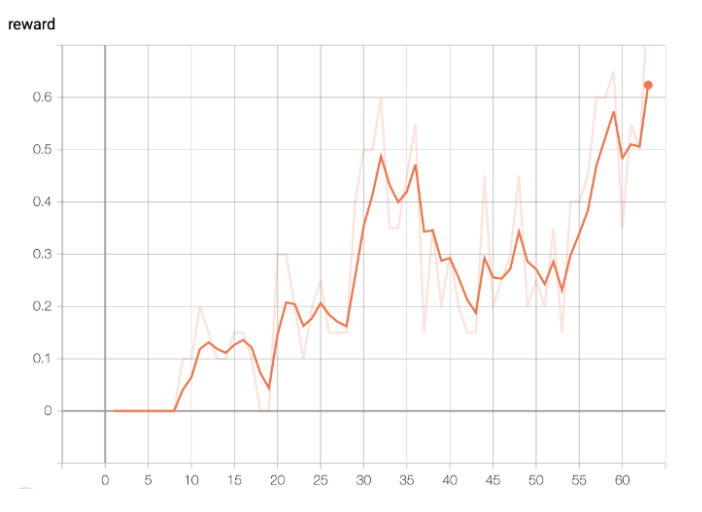

We can notice that in all cases, it needs a few seconds as a maximum to find a good policy that solves the Environment in 80% of runs. If you remember the Cross-Entropy method, for a slippery Environment, it took many hours to achieve a success rate of only 60%.